<a href="https://colab.research.google.com/github/ziednciri/Enhancement-of-Chest-X-ray-Classification-via-Advanced-Deep-Learning-Approaches/blob/main/Cprojet2s4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.7 MB/s eta 0:00:00


## **🩺 Analyse exploratoire du dataset NIH ChestX-ray14**

/tmp/ipython-input-3268346863.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")


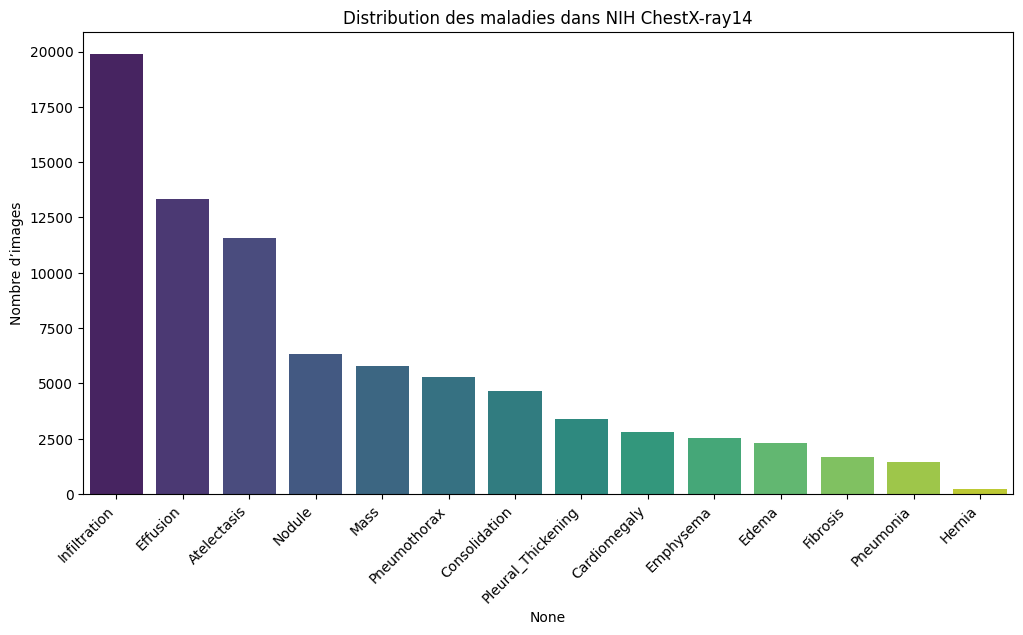

📊 Tableau distribution des maladies :
                    Count
Infiltration        19894
Effusion            13317
Atelectasis         11559
Nodule               6331
Mass                 5782
Pneumothorax         5302
Consolidation        4667
Pleural_Thickening   3385
Cardiomegaly         2776
Emphysema            2516
Edema                2303
Fibrosis             1686
Pneumonia            1431
Hernia                227


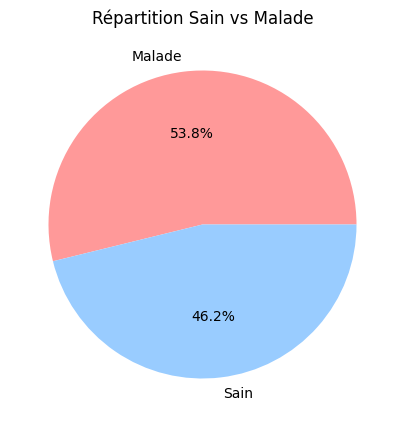

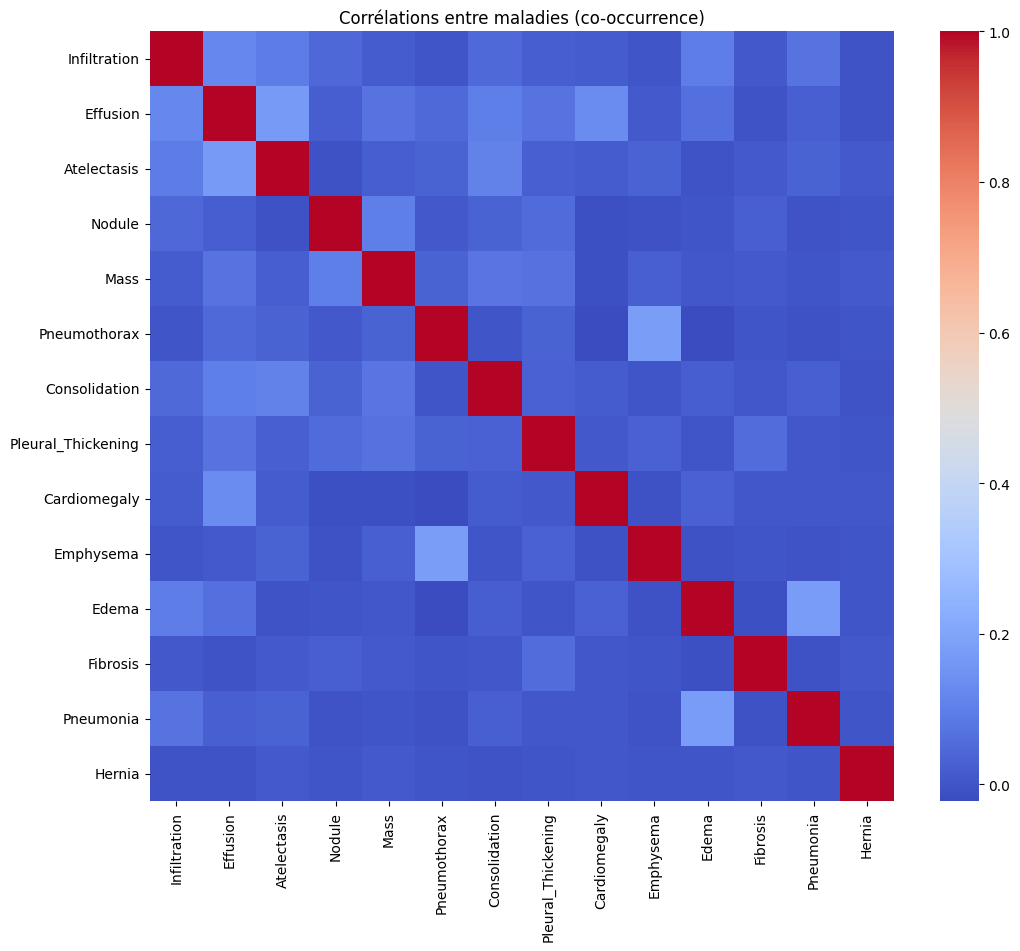

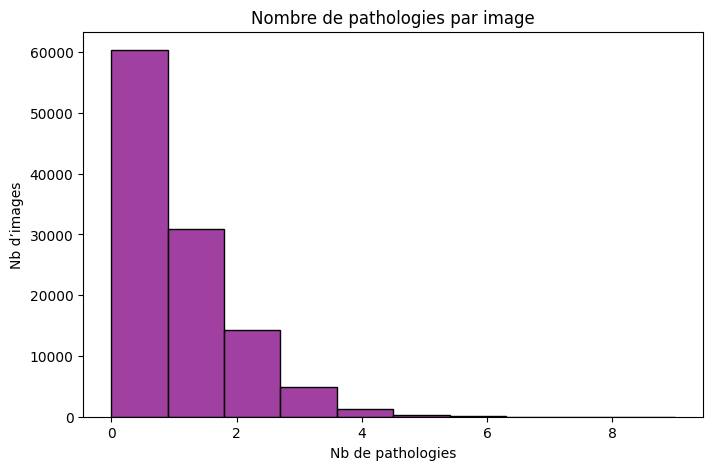

In [ ]:
# ==========================================================
# 📊 Analyse exploratoire du dataset
# ==========================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Recharger dataset complet
labels_df = pd.read_csv(csv_path)
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda x: x.split('|'))

# === 1. Distribution des maladies ===
from collections import Counter

disease_counts = Counter([d for sublist in labels_df['Finding Labels'] for d in sublist if d != "No Finding"])
disease_df = pd.DataFrame.from_dict(disease_counts, orient='index', columns=['Count']).sort_values("Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution des maladies dans NIH ChestX-ray14")
plt.ylabel("Nombre d’images")
plt.show()

print("📊 Tableau distribution des maladies :")
print(disease_df)

# === 2. Répartition No Finding vs Malades ===
labels_df['is_healthy'] = labels_df['Finding Labels'].apply(lambda x: 1 if "No Finding" in x else 0)
healthy_vs_disease = labels_df['is_healthy'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(healthy_vs_disease, labels=["Malade","Sain"], autopct='%1.1f%%', colors=["#FF9999","#99CCFF"])
plt.title("Répartition Sain vs Malade")
plt.show()

# === 3. Corrélations entre maladies (co-occurrence) ===
from itertools import combinations
import numpy as np

# Créer matrice binaire
diseases = disease_df.index.tolist()
binary_matrix = np.zeros((len(labels_df), len(diseases)))

for i, row in enumerate(labels_df['Finding Labels']):
    for j, d in enumerate(diseases):
        if d in row:
            binary_matrix[i,j] = 1

corr_matrix = np.corrcoef(binary_matrix.T)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, xticklabels=diseases, yticklabels=diseases, cmap="coolwarm", annot=False)
plt.title("Corrélations entre maladies (co-occurrence)")
plt.show()

# === 4. Histogramme du nombre de pathologies par patient ===
labels_df["n_pathologies"] = labels_df['Finding Labels'].apply(lambda x: len([d for d in x if d != "No Finding"]))
plt.figure(figsize=(8,5))
sns.histplot(labels_df["n_pathologies"], bins=10, kde=False, color="purple")
plt.title("Nombre de pathologies par image")
plt.xlabel("Nb de pathologies")
plt.ylabel("Nb d’images")
plt.show()



## **🩺 Analyse exploratoire du dataset NIH ChestX-ray14 par dossier**

✅ 4989 images trouvées dans le dossier /content/drive/MyDrive/NIH_ChestXray/images_001


/tmp/ipython-input-3733859735.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")


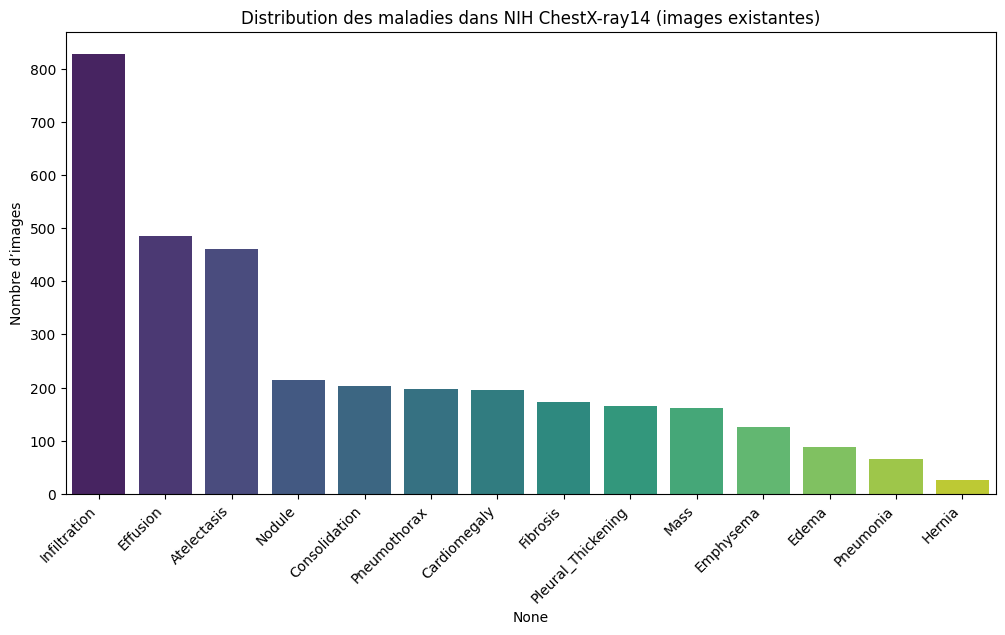

⚖️ Déséquilibre des classes (top 10) :
                    Count  Pourcentage
Infiltration          828    16.596512
Effusion              485     9.721387
Atelectasis           460     9.220285
Nodule                214     4.289437
Consolidation         203     4.068952
Pneumothorax          198     3.968731
Cardiomegaly          195     3.908599
Fibrosis              172     3.447585
Pleural_Thickening    165     3.307276
Mass                  161     3.227100


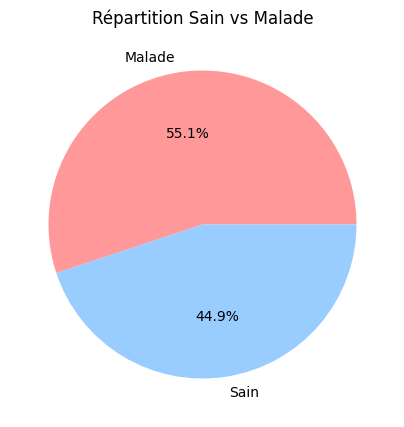

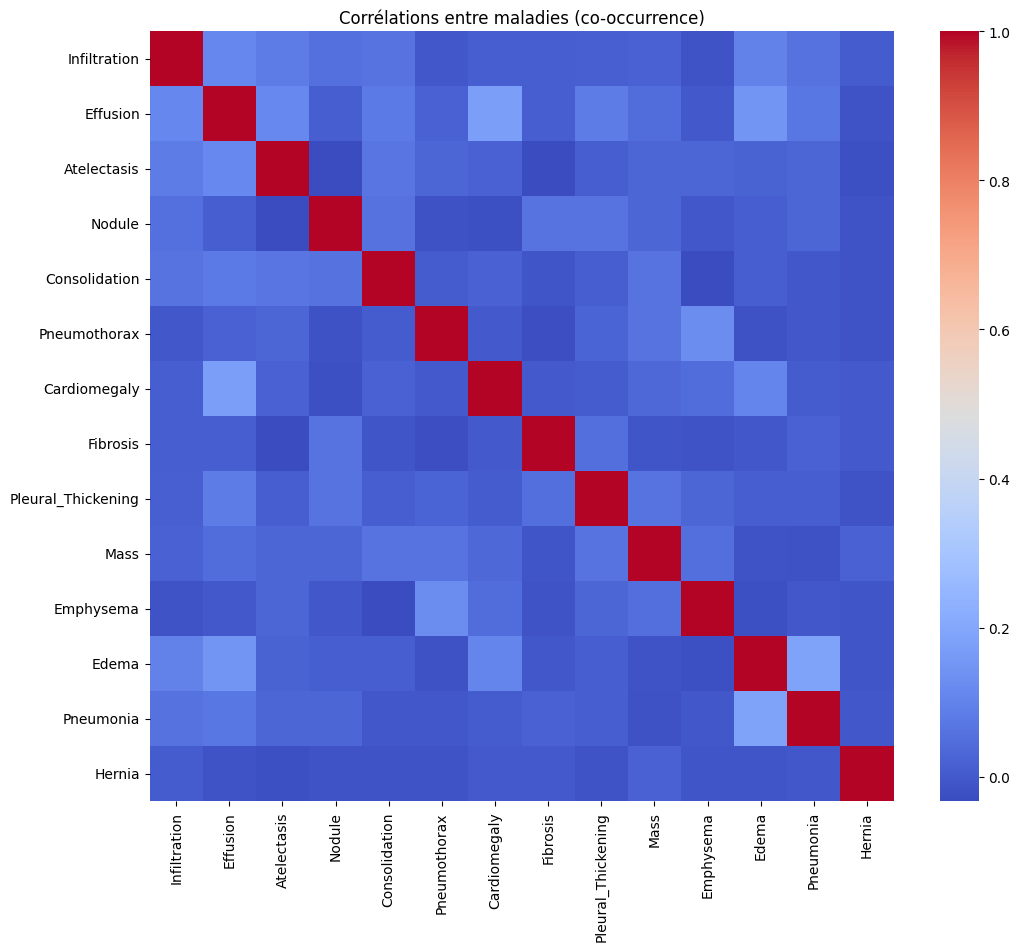

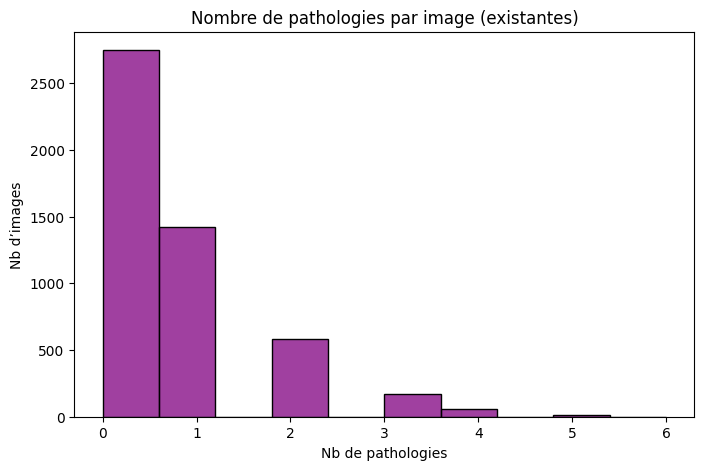

📏 Lecture des dimensions (échantillon de 1000 images max)...


100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


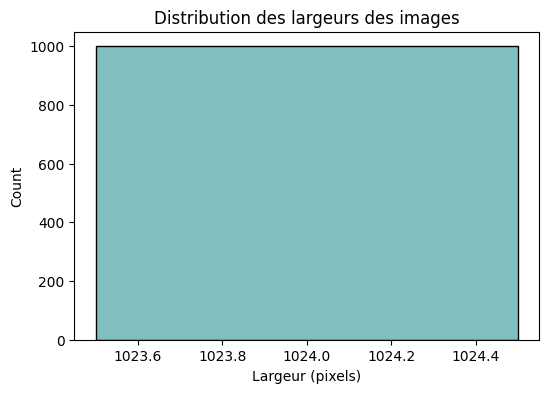

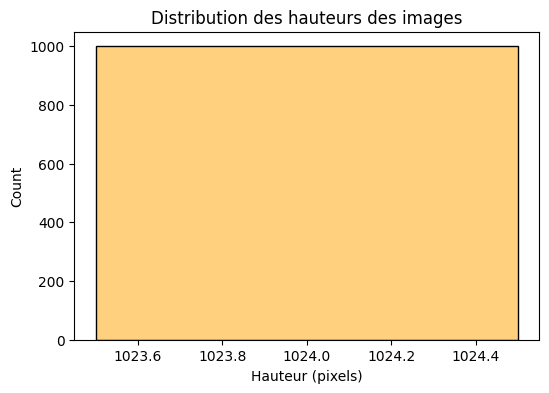

📏 Moyenne largeur : 1024.0px | hauteur : 1024.0px


/tmp/ipython-input-3733859735.py:140: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


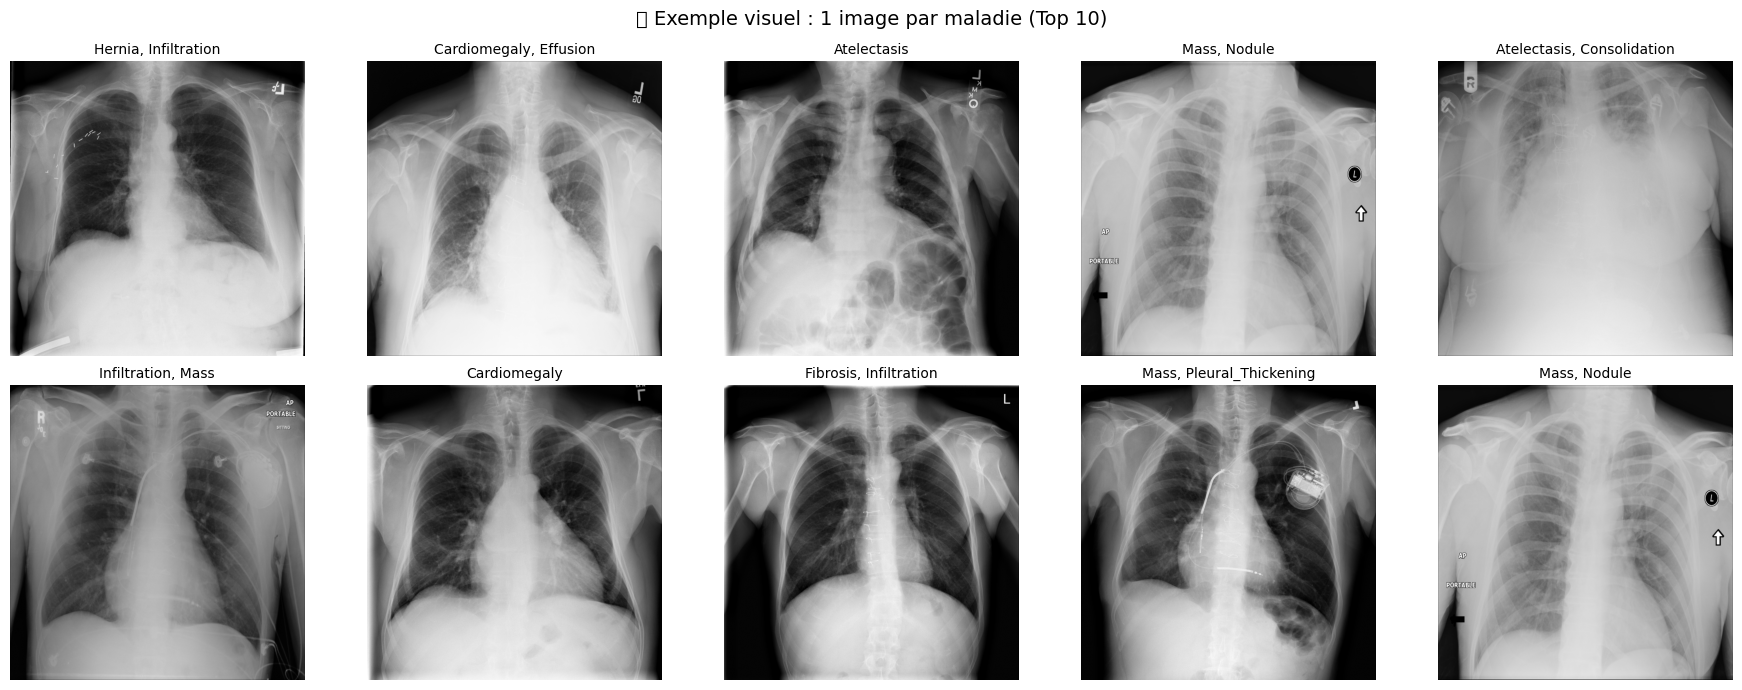

In [ ]:
# ==========================================================
# 📊 Analyse exploratoire complète (préparation au prétraitement)
# ==========================================================
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm import tqdm

# === 0. Chargement du dataset ===
data_dir = "/content/drive/MyDrive/NIH_ChestXray"
csv_path = os.path.join(data_dir, "Data_Entry_2017.csv")
images_dir = os.path.join(data_dir, "images_001")

# Charger CSV d'annotations
labels_df = pd.read_csv(csv_path)
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda x: x.split('|'))

# Filtrer uniquement les images existantes
existing_images = set(os.listdir(images_dir))
labels_df = labels_df[labels_df["Image Index"].isin(existing_images)]
print(f"✅ {len(labels_df)} images trouvées dans le dossier {images_dir}")

# ==========================================================
# 🩺 1. Distribution des maladies
# ==========================================================
disease_counts = Counter([d for sublist in labels_df['Finding Labels'] for d in sublist if d != "No Finding"])
disease_df = pd.DataFrame.from_dict(disease_counts, orient='index', columns=['Count']).sort_values("Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution des maladies dans NIH ChestX-ray14 (images existantes)")
plt.ylabel("Nombre d’images")
plt.show()

# 🔍 Analyse d’équilibre des classes
total_images = len(labels_df)
disease_df["Pourcentage"] = (disease_df["Count"] / total_images) * 100
print("⚖️ Déséquilibre des classes (top 10) :")
print(disease_df.head(10))

# ==========================================================
# 🍀 2. Répartition Sain vs Malade
# ==========================================================
labels_df['is_healthy'] = labels_df['Finding Labels'].apply(lambda x: 1 if "No Finding" in x else 0)
healthy_vs_disease = labels_df['is_healthy'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(healthy_vs_disease, labels=["Malade","Sain"], autopct='%1.1f%%', colors=["#FF9999","#99CCFF"])
plt.title("Répartition Sain vs Malade")
plt.show()

# ==========================================================
# 🔗 3. Corrélations entre maladies
# ==========================================================
diseases = disease_df.index.tolist()
binary_matrix = np.zeros((len(labels_df), len(diseases)))

for i, row in enumerate(labels_df['Finding Labels']):
    for j, d in enumerate(diseases):
        if d in row:
            binary_matrix[i, j] = 1

corr_matrix = np.corrcoef(binary_matrix.T)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, xticklabels=diseases, yticklabels=diseases, cmap="coolwarm", annot=False)
plt.title("Corrélations entre maladies (co-occurrence)")
plt.show()

# ==========================================================
# 🧮 4. Nombre de pathologies par image
# ==========================================================
labels_df["n_pathologies"] = labels_df['Finding Labels'].apply(lambda x: len([d for d in x if d != "No Finding"]))
plt.figure(figsize=(8,5))
sns.histplot(labels_df["n_pathologies"], bins=10, kde=False, color="purple")
plt.title("Nombre de pathologies par image (existantes)")
plt.xlabel("Nb de pathologies")
plt.ylabel("Nb d’images")
plt.show()

# ==========================================================
# 📐 5. Analyse des tailles d'images
# ==========================================================
widths, heights = [], []

print("📏 Lecture des dimensions (échantillon de 1000 images max)...")
for img_name in tqdm(labels_df["Image Index"].sample(min(1000, len(labels_df)))):
    try:
        img_path = os.path.join(images_dir, img_name)
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        pass

plt.figure(figsize=(6,4))
sns.histplot(widths, kde=True, color='teal')
plt.title("Distribution des largeurs des images")
plt.xlabel("Largeur (pixels)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(heights, kde=True, color='orange')
plt.title("Distribution des hauteurs des images")
plt.xlabel("Hauteur (pixels)")
plt.show()

print(f"📏 Moyenne largeur : {np.mean(widths):.1f}px | hauteur : {np.mean(heights):.1f}px")

# ==========================================================
# 💡 6. Exemple visuel : 1 image par maladie (Top 10)
# ==========================================================
top10_diseases = disease_df.head(10).index.tolist()
sample_images = []

for disease in top10_diseases:
    subset = labels_df[labels_df['Finding Labels'].apply(lambda lst: disease in lst)]
    if not subset.empty:
        sample_images.append(subset.iloc[0])

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.flatten()

for i, row in enumerate(sample_images):
    img_path = os.path.join(images_dir, row["Image Index"])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(", ".join([d for d in row['Finding Labels'] if d != "No Finding"][:2]), fontsize=10)
    else:
        axes[i].text(0.5, 0.5, "Image manquante", ha="center", va="center", fontsize=8)
    axes[i].axis("off")

plt.suptitle("🩻 Exemple visuel : 1 image par maladie (Top 10)", fontsize=14)
plt.tight_layout()
plt.show()


# **Prétraitement et Augmentation**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 5 dossiers trouvés : ['/content/drive/MyDrive/NIH_ChestXray/images_001', '/content/drive/MyDrive/NIH_ChestXray/images_002', '/content/drive/MyDrive/NIH_ChestXray/images_003', '/content/drive/MyDrive/NIH_ChestXray/images_004', '/content/drive/MyDrive/NIH_ChestXray/images_test']

📦 Analyse du dossier : images_001


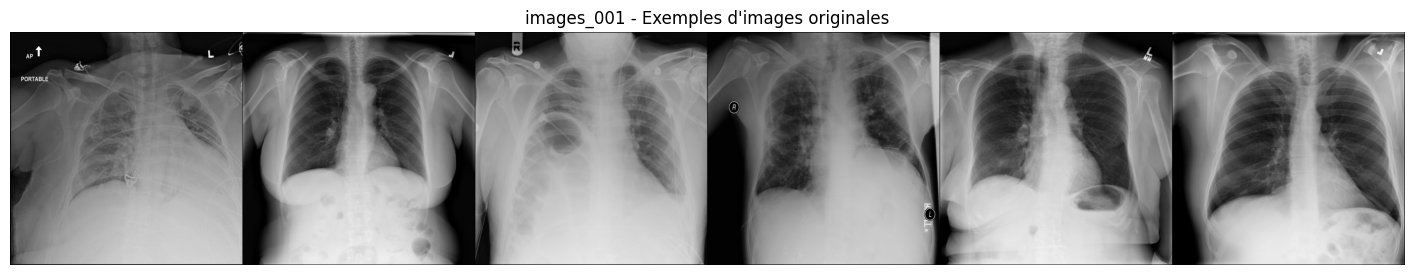

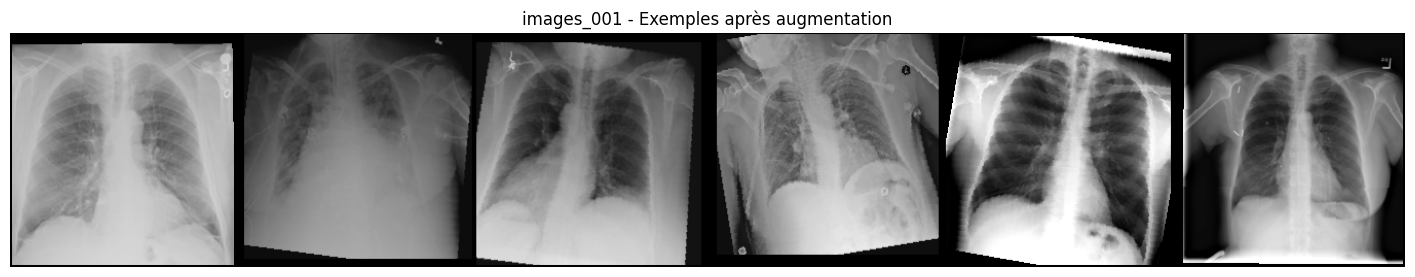

📈 Moyenne : [4.927630925521953e-07, 4.927630925521953e-07, 4.927630925521953e-07] | Écart-type : [0.00022885596263222396, 0.00022885596263222396, 0.00022885596263222396]

📦 Analyse du dossier : images_002


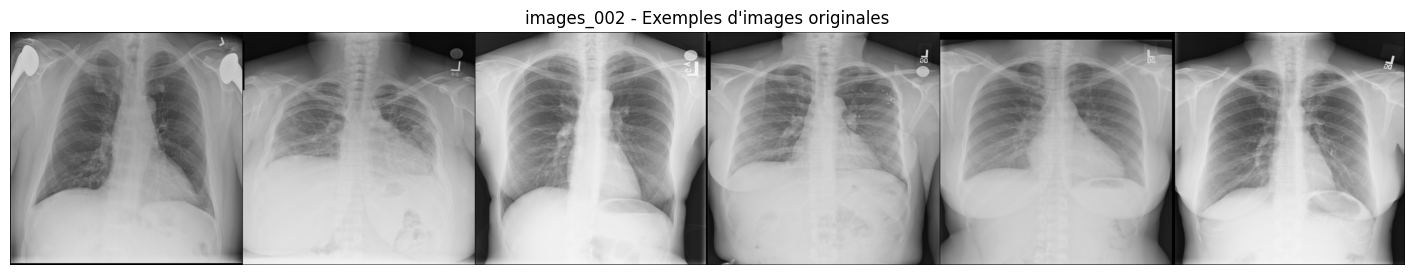

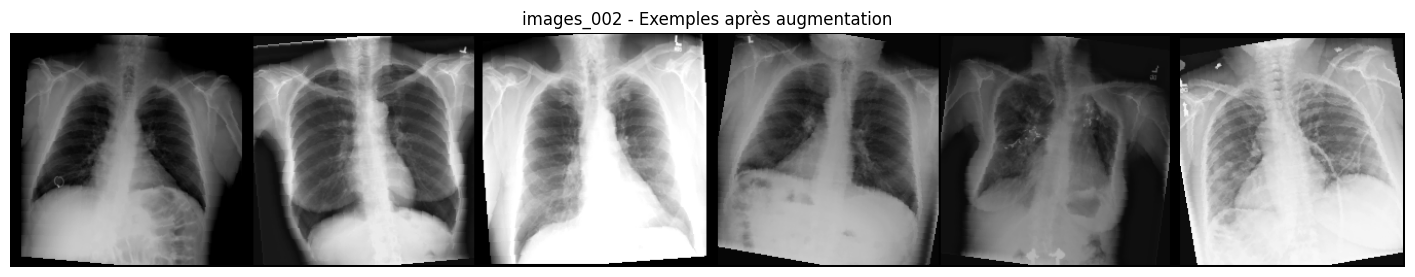

📈 Moyenne : [5.082711140858009e-07, 5.082711140858009e-07, 5.082711140858009e-07] | Écart-type : [0.00022344269382301718, 0.00022344269382301718, 0.00022344269382301718]

📦 Analyse du dossier : images_003
⚠️ Aucun fichier trouvé dans /content/drive/MyDrive/NIH_ChestXray/images_003

📦 Analyse du dossier : images_004


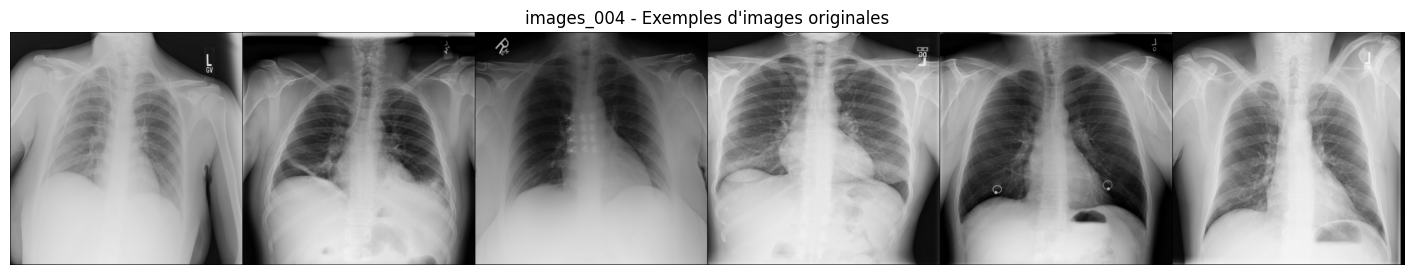

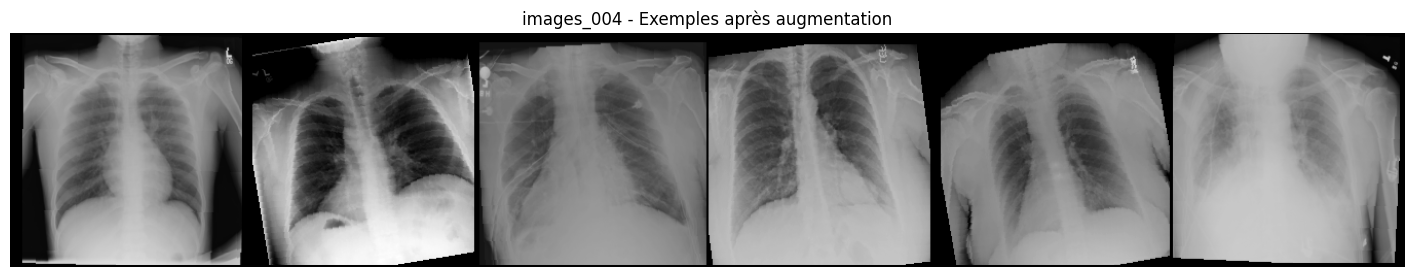

📈 Moyenne : [5.408830361375294e-07, 5.408830361375294e-07, 5.408830361375294e-07] | Écart-type : [0.0002201195020461455, 0.0002201195020461455, 0.0002201195020461455]

📦 Analyse du dossier : images_test
⚠️ Aucun fichier trouvé dans /content/drive/MyDrive/NIH_ChestXray/images_test


,folder,mean,std
0,images_001,"[4.927630925521953e-07, 4.927630925521953e-07,...","[0.00022885596263222396, 0.0002288559626322239..."
1,images_002,"[5.082711140858009e-07, 5.082711140858009e-07,...","[0.00022344269382301718, 0.0002234426938230171..."
2,images_004,"[5.408830361375294e-07, 5.408830361375294e-07,...","[0.0002201195020461455, 0.0002201195020461455,..."


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


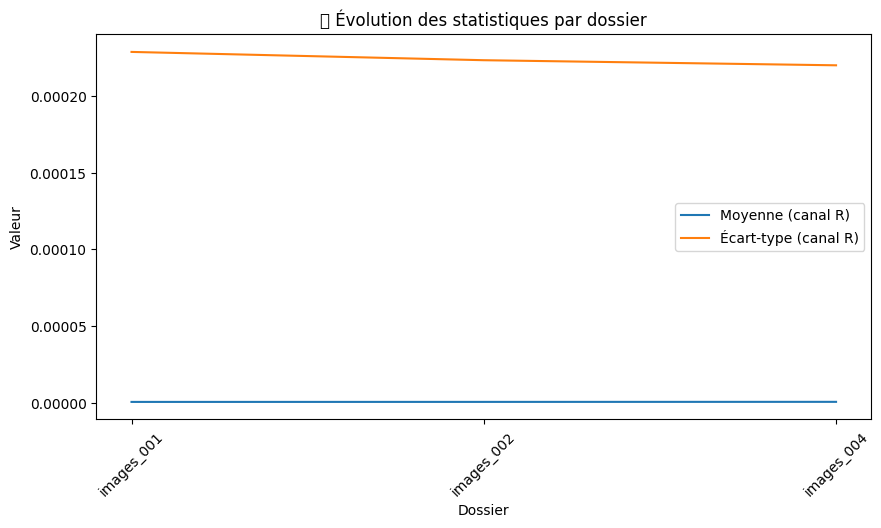

In [ ]:
# ==========================================================
# 🚀 1. Monter Google Drive
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

# ==========================================================
# 📁 2. Définir les chemins et dossiers
# ==========================================================
import os
import pandas as pd

data_dir = "/content/drive/MyDrive/NIH_ChestXray"
csv_path = os.path.join(data_dir, "Data_Entry_2017.csv")

# Lister les sous-dossiers d'images (images_001, images_002, ...)
image_folders = sorted([os.path.join(data_dir, d) for d in os.listdir(data_dir) if "images_" in d])
print(f"📂 {len(image_folders)} dossiers trouvés :", image_folders)

labels_df = pd.read_csv(csv_path)

# ==========================================================
# 🧹 3. Dataset et Loader
# ==========================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Image Index"])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(row["Finding Labels"] != "No Finding")).long()
        if self.transform:
            image = self.transform(image)
        return image, label

# ==========================================================
# 🧠 4. Prétraitement et Augmentation
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# --- Transformations ---
basic_tf = transforms.ToTensor()

transform_final = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5174]*3, [0.2298]*3)
])

augment_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5174]*3, [0.2298]*3)
])

# ==========================================================
# 📊 5. Fonction utilitaire pour stats et visualisation
# ==========================================================
def compute_dataset_stats(dataloader, max_batches=50):
    n_pixels = 0
    mean = 0.
    var = 0.
    for i, (imgs, _) in enumerate(dataloader):
        if i >= max_batches: break
        imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
        n_pixels += imgs.size(0) * imgs.size(2)
        mean += imgs.mean(2).sum(0)
        var += imgs.var(2).sum(0)
    mean /= n_pixels
    std = torch.sqrt(var / n_pixels)
    return mean, std

# ==========================================================
# 🔁 6. Boucle dossier par dossier
# ==========================================================
stats_list = []

for folder in image_folders:
    folder_name = os.path.basename(folder)
    print(f"\n📦 Analyse du dossier : {folder_name}")

    # Extraire les images correspondant à ce dossier
    images_in_folder = [f for f in os.listdir(folder) if f.endswith(".png")]
    df_subset = labels_df[labels_df["Image Index"].isin(images_in_folder)]

    if len(df_subset) == 0:
        print(f"⚠️ Aucun fichier trouvé dans {folder}")
        continue

    # Loader pour un échantillon (limité pour la visualisation)
    sample_loader = DataLoader(
        ChestXrayDataset(df_subset.sample(min(6, len(df_subset))), folder, transform=basic_tf),
        batch_size=6, shuffle=False
    )

    # === Affichage images originales ===
    images, _ = next(iter(sample_loader))
    grid = torchvision.utils.make_grid(images, nrow=6, normalize=True)
    plt.figure(figsize=(18,4))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off")
    plt.title(f"{folder_name} - Exemples d'images originales")
    plt.show()

    # === Images après augmentation ===
    aug_loader = DataLoader(
        ChestXrayDataset(df_subset.sample(min(6, len(df_subset))), folder, transform=augment_tf),
        batch_size=6, shuffle=False
    )
    images_aug, _ = next(iter(aug_loader))
    grid_aug = torchvision.utils.make_grid(images_aug, nrow=6, normalize=True)
    plt.figure(figsize=(18,4))
    plt.imshow(np.transpose(grid_aug.numpy(), (1,2,0)))
    plt.axis("off")
    plt.title(f"{folder_name} - Exemples après augmentation")
    plt.show()

    # === Statistiques du dossier ===
    mini_loader = DataLoader(
        ChestXrayDataset(df_subset.sample(min(300, len(df_subset))), folder, transform=basic_tf),
        batch_size=16, shuffle=False
    )
    mean, std = compute_dataset_stats(mini_loader)
    print(f"📈 Moyenne : {mean.tolist()} | Écart-type : {std.tolist()}")
    stats_list.append({"folder": folder_name, "mean": mean.tolist(), "std": std.tolist()})

# ==========================================================
# 📘 7. Résumé global
# ==========================================================
stats_df = pd.DataFrame(stats_list)
display(stats_df)

plt.figure(figsize=(10,5))
plt.plot(stats_df["folder"], [m[0] for m in stats_df["mean"]], label="Moyenne (canal R)")
plt.plot(stats_df["folder"], [s[0] for s in stats_df["std"]], label="Écart-type (canal R)")
plt.xticks(rotation=45)
plt.xlabel("Dossier")
plt.ylabel("Valeur")
plt.title("📊 Évolution des statistiques par dossier")
plt.legend()
plt.show()


# **Swin Transformer multi-label, per-folder training with resume-from-previous-folder checkpointing**

Mounted at /content/drive
Device: cpu
CSV loaded: 112120 rows
Detected 14 diseases.
Pos-weight per class computed.
Found image folders: ['/content/drive/MyDrive/NIH_ChestXray/images_001']
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:01<00:00, 62.7MB/s]


📦 Loading checkpoint from: /content/drive/MyDrive/NIH_ChestXray/models_by_folder/common_checkpoint.pth
⚠️ Deserialization issue, reloading with weights_only=False ...
✅ Model weights loaded.
⚙️ Optimizer state loaded.

📂 Training on folder 1/1: images_001


Train [images_001] E1:   0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📈 images_001 | Epoch 1: TrainLoss=1.3373, ValLoss=1.3414, AUC=0.6607, F1=0.1139
💾 Global checkpoint saved: /content/drive/MyDrive/NIH_ChestXray/models_by_folder/common_checkpoint.pth


Train [images_001] E2:   0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📈 images_001 | Epoch 2: TrainLoss=1.3154, ValLoss=1.3081, AUC=0.6919, F1=0.1303
💾 Global checkpoint saved: /content/drive/MyDrive/NIH_ChestXray/models_by_folder/common_checkpoint.pth
🔍 Feature extraction + PCA for images_001 ...


Feature extraction [images_001]:   0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Feature extraction [images_001]: 100%|██████████| 63/63 [04:41<00:00,  4.47s/it]


features_all.shape: (998, 768)
labels_all.shape: (998, 14)
PCA done: components=128, explained variance=99.73%
Saved PCA features to: /content/drive/MyDrive/NIH_ChestXray/models_by_folder/features_pca_images_001.npy and /content/drive/MyDrive/NIH_ChestXray/models_by_folder/pca_features_images_001.csv


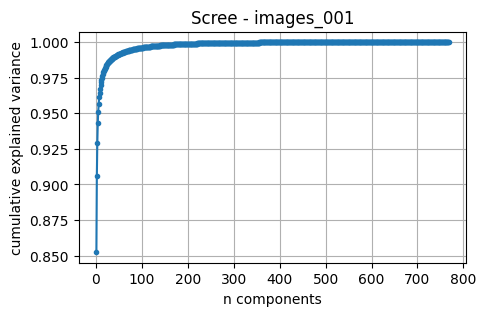

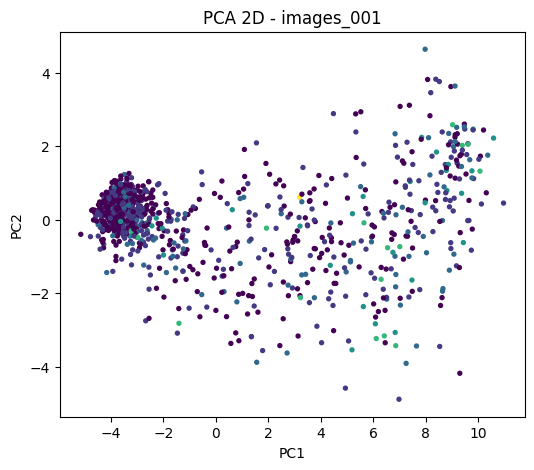

✅ Cumulative training & PCA finished for all folders.


In [ ]:
# -----------------------------
# 0) Mount Drive
# -----------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# -----------------------------
# 1) Imports & paths
# -----------------------------
import os, math, time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import swin_t
import torchvision
from tqdm import tqdm

# Paths (change if needed)
DATA_DIR = "/content/drive/MyDrive/NIH_ChestXray"
CSV_PATH = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
RESULTS_CSV = os.path.join(DATA_DIR, "training_results_swin.csv")
MODELS_DIR = os.path.join(DATA_DIR, "models_by_folder")
os.makedirs(MODELS_DIR, exist_ok=True)

# -----------------------------
# 2) Hyperparams
# -----------------------------
NUM_EPOCHS = 2           # epochs per folder
BATCH_SIZE = 16
LR = 1e-4
IMG_SIZE = 224
NUM_WORKERS = 2           # adjust for your runtime
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

# -----------------------------
# 3) Load CSV and build disease list (multi-label)
# -----------------------------
df = pd.read_csv(CSV_PATH)
print("CSV loaded:", len(df), "rows")
df["Finding Labels"] = df["Finding Labels"].astype(str)

all_labels = sorted(set(
    lab for cell in df["Finding Labels"] for lab in cell.split("|")
    if lab and lab.strip() != "No Finding"
))
print(f"Detected {len(all_labels)} diseases.")
for disease in all_labels:
    df[disease] = df["Finding Labels"].apply(lambda x: 1 if disease in x.split("|") else 0)

# -----------------------------
# Helper: compute per-class pos_weight (optional)
# -----------------------------
pos_weight = None
try:
    pos_counts = df[all_labels].sum(axis=0).values.astype(float)
    neg_counts = len(df) - pos_counts
    pos_weight_arr = (neg_counts / (pos_counts + 1e-6)).astype(np.float32)
    pos_weight = torch.tensor(pos_weight_arr).to(DEVICE)
    print("Pos-weight per class computed.")
except Exception as e:
    print("Could not compute pos_weight:", e)
    pos_weight = None

# -----------------------------
# 4) Image folders (all images_*)
# -----------------------------
image_folders = sorted([os.path.join(DATA_DIR, d) for d in os.listdir(DATA_DIR) if d.startswith("images_")])
print("Found image folders:", image_folders)

# -----------------------------
# 5) Dataset class (multi-label)
# -----------------------------
class ChestXrayMultiLabelDataset(Dataset):
    def __init__(self, df, img_folder, label_cols, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_folder = img_folder
        self.label_cols = label_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["Image Index"]
        img_path = os.path.join(self.img_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        return image, labels

# -----------------------------
# 6) Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5174,0.5174,0.5174], [0.2298,0.2298,0.2298])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5174,0.5174,0.5174], [0.2298,0.2298,0.2298])
])

# -----------------------------
# 7) Metrics functions
# -----------------------------
def compute_metrics_multi(y_true, y_probs, threshold=0.5):
    C = y_true.shape[1]
    aucs, precs, recs, f1s = [], [], [], []
    for c in range(C):
        try:
            aucs.append(roc_auc_score(y_true[:, c], y_probs[:, c]))
        except Exception:
            aucs.append(np.nan)
        preds = (y_probs[:, c] >= threshold).astype(int)
        precs.append(precision_score(y_true[:, c], preds, zero_division=0))
        recs.append(recall_score(y_true[:, c], preds, zero_division=0))
        f1s.append(f1_score(y_true[:, c], preds, zero_division=0))
    return {
        "auc_mean": np.nanmean(aucs),
        "precision_mean": np.mean(precs),
        "recall_mean": np.mean(recs),
        "f1_mean": np.mean(f1s)
    }

# -----------------------------
# 8) Model builder (Swin) - multi-label head
# -----------------------------
def build_swin(num_classes, pretrained=True):
    model = swin_t(weights="IMAGENET1K_V1" if pretrained else None)
    # Replace head with multi-label linear layer.
    try:
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    except Exception:
        # Some torchvision versions use a sequential head
        # Try to find the last linear layer
        children = list(model.head.children())
        for i in range(len(children)-1, -1, -1):
            if isinstance(children[i], nn.Linear):
                in_features = children[i].in_features
                children[i] = nn.Linear(in_features, num_classes)
                model.head = nn.Sequential(*children)
                break
    return model

# Helper to extract features (robust)
def extract_features_from_model(model, x):
    """
    Returns a tensor of shape [B, C, H, W] for given input x.
    Tries common APIs: forward_features, then submodule children fallback.
    """
    model = model.eval()
    if hasattr(model, "forward_features"):
        return model.forward_features(x)  # some swin implementations provide this
    # fallback: remove final head module (heuristic)
    with torch.no_grad():
        # Try building a Sequential of all children except last (head)
        children = list(model.children())
        if len(children) > 0:
            # If last child is head, use everything before it
            backbone = nn.Sequential(*children[:-1])
            return backbone(x)
    raise RuntimeError("Could not extract features: adapt extract_features_from_model() for your model version.")

# -----------------------------
# 9) Checkpoint helpers (robust)
# -----------------------------
import numpy
def save_checkpoint(save_path, epoch, model, optimizer=None, metrics=None):
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict() if optimizer is not None else None,
        "metrics": metrics
    }
    # save using default serialization
    torch.save(state, save_path)
    return save_path

def load_checkpoint(ckpt_path, model, optimizer=None, map_location="cpu"):
    print(f"📦 Loading checkpoint from: {ckpt_path}")
    try:
        state = torch.load(ckpt_path, map_location=map_location)
    except Exception as e:
        # fallback for PyTorch >=2.6 weights_only restriction
        print("⚠️ Deserialization issue, reloading with weights_only=False ...")
        state = torch.load(ckpt_path, map_location=map_location, weights_only=False)

    # Load model weights
    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
    else:
        # checkpoint may be weights only
        model.load_state_dict(state)
    print("✅ Model weights loaded.")

    if optimizer is not None and isinstance(state, dict) and state.get("optimizer_state_dict", None) is not None:
        try:
            optimizer.load_state_dict(state["optimizer_state_dict"])
            print("⚙️ Optimizer state loaded.")
        except Exception as e:
            print("⚠️ Could not fully load optimizer:", e)

    return state

# -----------------------------
# 10) Main loop (global checkpoint)
# -----------------------------
if not os.path.exists(RESULTS_CSV):
    pd.DataFrame(columns=["Folder","Epoch","TrainLoss","ValLoss","ValAUC","ValPrecision","ValRecall","ValF1"]).to_csv(RESULTS_CSV, index=False)

COMMON_CKPT_PATH = os.path.join(MODELS_DIR, "common_checkpoint.pth")

num_classes = len(all_labels)
model = build_swin(num_classes, pretrained=True).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

start_epoch_global = 1
if os.path.exists(COMMON_CKPT_PATH):
    state = load_checkpoint(COMMON_CKPT_PATH, model, optimizer)
    start_epoch_global = state.get("epoch", 0) + 1

for i, folder in enumerate(image_folders):
    folder_name = os.path.basename(folder)
    print("\n" + "="*60)
    print(f"📂 Training on folder {i+1}/{len(image_folders)}: {folder_name}")
    print("="*60)

    imgs_in_folder = set([f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
    df_folder = df[df["Image Index"].isin(imgs_in_folder)].reset_index(drop=True)
    if len(df_folder) == 0:
        print(f"⚠️ No samples in {folder_name}, skip.")
        continue

    train_df, val_df = train_test_split(df_folder, test_size=0.2, random_state=42)
    train_loader = DataLoader(
        ChestXrayMultiLabelDataset(train_df, folder, all_labels, train_transform),
        batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
    )
    val_loader = DataLoader(
        ChestXrayMultiLabelDataset(val_df, folder, all_labels, val_transform),
        batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
    )

    # Train for NUM_EPOCHS on this folder
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_loss = 0.0
        for imgs, labels in tqdm(train_loader, desc=f"Train [{folder_name}] E{epoch}", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = loss_fn(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)

        train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        all_probs, all_targets = [], []
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Val [{folder_name}] E{epoch}", leave=False):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                out = model(imgs)
                val_loss += loss_fn(out, labels).item() * imgs.size(0)
                all_probs.append(torch.sigmoid(out).cpu().numpy())
                all_targets.append(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        all_probs = np.vstack(all_probs)
        all_targets = np.vstack(all_targets)
        metrics = compute_metrics_multi(all_targets, all_probs)

        print(f"📈 {folder_name} | Epoch {epoch}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, AUC={metrics['auc_mean']:.4f}, F1={metrics['f1_mean']:.4f}")

        # Save global checkpoint
        save_checkpoint(COMMON_CKPT_PATH, epoch + start_epoch_global - 1, model, optimizer, metrics)
        print("💾 Global checkpoint saved:", COMMON_CKPT_PATH)

        # Append to CSV
        pd.concat([
            pd.read_csv(RESULTS_CSV),
            pd.DataFrame([{
                "Folder": folder_name,
                "Epoch": epoch + start_epoch_global - 1,
                "TrainLoss": train_loss,
                "ValLoss": val_loss,
                "ValAUC": metrics["auc_mean"],
                "ValPrecision": metrics["precision_mean"],
                "ValRecall": metrics["recall_mean"],
                "ValF1": metrics["f1_mean"]
            }])
        ], ignore_index=True).to_csv(RESULTS_CSV, index=False)

    start_epoch_global += NUM_EPOCHS

    # ==========================================
    # 🔍 PCA and feature extraction AFTER training on folder
    # ==========================================
    print(f"🔍 Feature extraction + PCA for {folder_name} ...")
    model.eval()
    features_list, labels_list = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Feature extraction [{folder_name}]"):
            imgs = imgs.to(DEVICE)
            # robust extraction
            feats = extract_features_from_model(model, imgs)  # [B, C, H, W] expected
            # If returned shape is [B, C] (already pooled), handle:
            if feats.dim() == 2:
                feats_flat = feats  # already [B, C]
            else:
                feats_flat = feats.mean(dim=[2,3])  # global pooling -> [B, C]
            features_list.append(feats_flat.cpu().numpy())
            labels_list.append(labels.numpy())

    features_all = np.vstack(features_list)  # (N_val, C)
    labels_all = np.vstack(labels_list)

    # safe-check shapes
    print("features_all.shape:", features_all.shape)
    print("labels_all.shape:", labels_all.shape)

    # -------------------------
    # PCA (robust)
    # -------------------------
    # Try fixed target dim 128 but fallback if not enough samples
    target_dim = 128
    n_samples, n_features = features_all.shape
    max_allowed = min(n_samples, n_features)
    if target_dim > max_allowed:
        print(f"⚠️ Too few samples/features for n_components={target_dim}. Using n_components={max_allowed}")
        target_dim = max_allowed if max_allowed > 0 else 1

    # Fit PCA
    pca = PCA(n_components=target_dim)
    features_reduced = pca.fit_transform(features_all)
    explained = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA done: components={features_reduced.shape[1]}, explained variance={explained:.2f}%")

    # Optionally L2-normalize reduced vectors for similarity tasks
    features_reduced_norm = normalize(features_reduced, norm="l2", axis=1)

    # Save features (binary + csv)
    out_npy = os.path.join(MODELS_DIR, f"features_pca_{folder_name}.npy")
    out_csv = os.path.join(MODELS_DIR, f"pca_features_{folder_name}.csv")
    np.save(out_npy, features_reduced_norm)
    pd.DataFrame(features_reduced).to_csv(out_csv, index=False)
    print("Saved PCA features to:", out_npy, "and", out_csv)

    # -------------------------
    # Scree plot (explained variance cumulative)
    # -------------------------
    try:
        pca_full = PCA().fit(features_all)
        cumvar = np.cumsum(pca_full.explained_variance_ratio_)
        plt.figure(figsize=(5,3))
        plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='.')
        plt.xlabel("n components"); plt.ylabel("cumulative explained variance")
        plt.title(f"Scree - {folder_name}")
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Could not plot scree:", e)

    # -------------------------
    # 2D visualization via PCA (for quick check)
    # -------------------------
    try:
        pca2 = PCA(n_components=2)
        reduced_2d = pca2.fit_transform(features_all)
        plt.figure(figsize=(6,5))
        plt.scatter(reduced_2d[:,0], reduced_2d[:,1], c=labels_all.sum(axis=1), cmap="viridis", s=8)
        plt.title(f"PCA 2D - {folder_name}")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.show()
    except Exception as e:
        print("Could not plot 2D PCA:", e)

print("✅ Cumulative training & PCA finished for all folders.")


# PCA and feature extraction AFTER training on folder

🔍 Feature extraction + PCA for images_001 ...


Feature extraction [images_001]: 100%|██████████| 63/63 [09:43<00:00,  9.27s/it]


features_all.shape: (998, 768)
labels_all.shape: (998, 14)
PCA done: components=128, explained variance=99.73%
Saved PCA features to: /content/drive/MyDrive/NIH_ChestXray/models_by_folder/features_pca_images_001.npy and /content/drive/MyDrive/NIH_ChestXray/models_by_folder/pca_features_images_001.csv


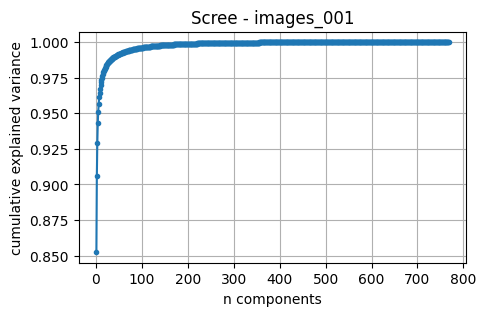

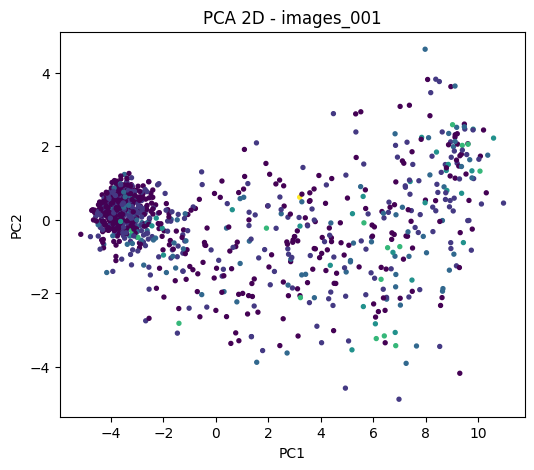

✅ Cumulative training & PCA finished for all folders.


In [ ]:
    # ==========================================
    # 🔍 PCA and feature extraction AFTER training on folder
    # ==========================================
    print(f"🔍 Feature extraction + PCA for {folder_name} ...")
    model.eval()
    features_list, labels_list = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Feature extraction [{folder_name}]"):
            imgs = imgs.to(DEVICE)
            # robust extraction
            feats = extract_features_from_model(model, imgs)  # [B, C, H, W] expected
            # If returned shape is [B, C] (already pooled), handle:
            if feats.dim() == 2:
                feats_flat = feats  # already [B, C]
            else:
                feats_flat = feats.mean(dim=[2,3])  # global pooling -> [B, C]
            features_list.append(feats_flat.cpu().numpy())
            labels_list.append(labels.numpy())

    features_all = np.vstack(features_list)  # (N_val, C)
    labels_all = np.vstack(labels_list)

    # safe-check shapes
    print("features_all.shape:", features_all.shape)
    print("labels_all.shape:", labels_all.shape)

    # -------------------------
    # PCA (robust)
    # -------------------------
    # Try fixed target dim 128 but fallback if not enough samples
    target_dim = 128
    n_samples, n_features = features_all.shape
    max_allowed = min(n_samples, n_features)
    if target_dim > max_allowed:
        print(f"⚠️ Too few samples/features for n_components={target_dim}. Using n_components={max_allowed}")
        target_dim = max_allowed if max_allowed > 0 else 1

    # Fit PCA
    pca = PCA(n_components=target_dim)
    features_reduced = pca.fit_transform(features_all)
    explained = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA done: components={features_reduced.shape[1]}, explained variance={explained:.2f}%")

    # Optionally L2-normalize reduced vectors for similarity tasks
    features_reduced_norm = normalize(features_reduced, norm="l2", axis=1)

    # Save features (binary + csv)
    out_npy = os.path.join(MODELS_DIR, f"features_pca_{folder_name}.npy")
    out_csv = os.path.join(MODELS_DIR, f"pca_features_{folder_name}.csv")
    np.save(out_npy, features_reduced_norm)
    pd.DataFrame(features_reduced).to_csv(out_csv, index=False)
    print("Saved PCA features to:", out_npy, "and", out_csv)

    # -------------------------
    # Scree plot (explained variance cumulative)
    # -------------------------
    try:
        pca_full = PCA().fit(features_all)
        cumvar = np.cumsum(pca_full.explained_variance_ratio_)
        plt.figure(figsize=(5,3))
        plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='.')
        plt.xlabel("n components"); plt.ylabel("cumulative explained variance")
        plt.title(f"Scree - {folder_name}")
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Could not plot scree:", e)

    # -------------------------
    # 2D visualization via PCA (for quick check)
    # -------------------------
    try:
        pca2 = PCA(n_components=2)
        reduced_2d = pca2.fit_transform(features_all)
        plt.figure(figsize=(6,5))
        plt.scatter(reduced_2d[:,0], reduced_2d[:,1], c=labels_all.sum(axis=1), cmap="viridis", s=8)
        plt.title(f"PCA 2D - {folder_name}")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.show()
    except Exception as e:
        print("Could not plot 2D PCA:", e)

print("✅ Cumulative training & PCA finished for all folders.")

# **Évolution des performances Swin Transformer**

Mounted at /content/drive
Dossiers présents : ['images_001' 'images_002']
Colonnes disponibles : ['Folder', 'Epoch', 'TrainLoss', 'ValLoss', 'ValAUC', 'ValPrecision', 'ValRecall', 'ValF1']


/tmp/ipython-input-575819632.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


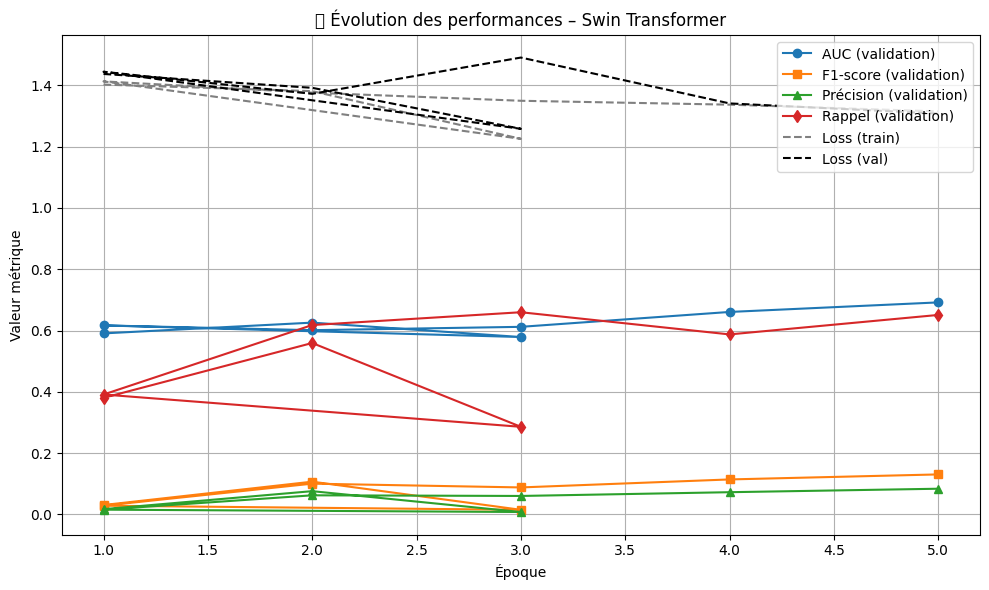

/tmp/ipython-input-575819632.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Folder', y='ValAUC', palette='viridis')


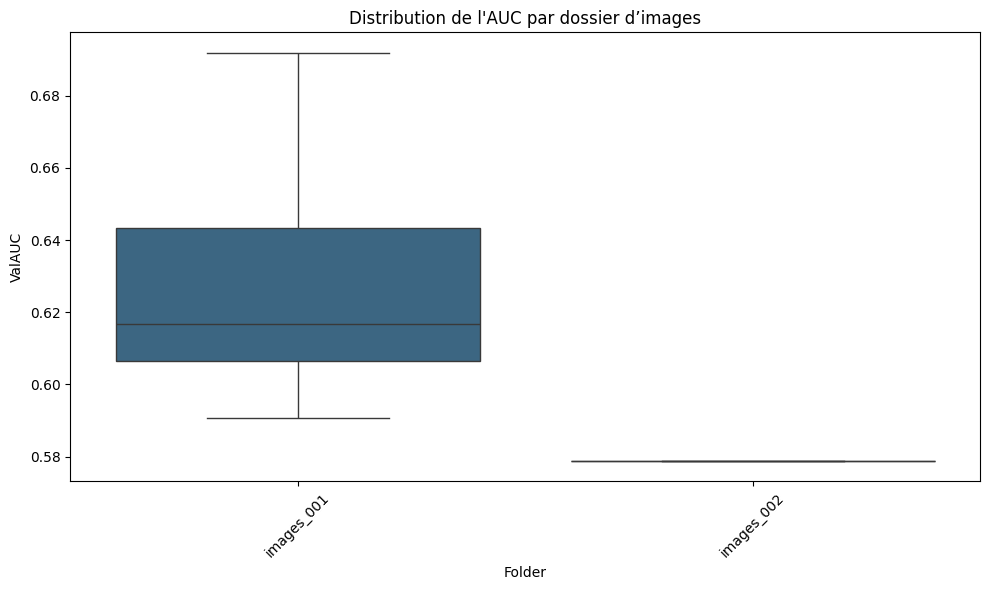

/tmp/ipython-input-575819632.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Folder', y='ValF1', palette='coolwarm')


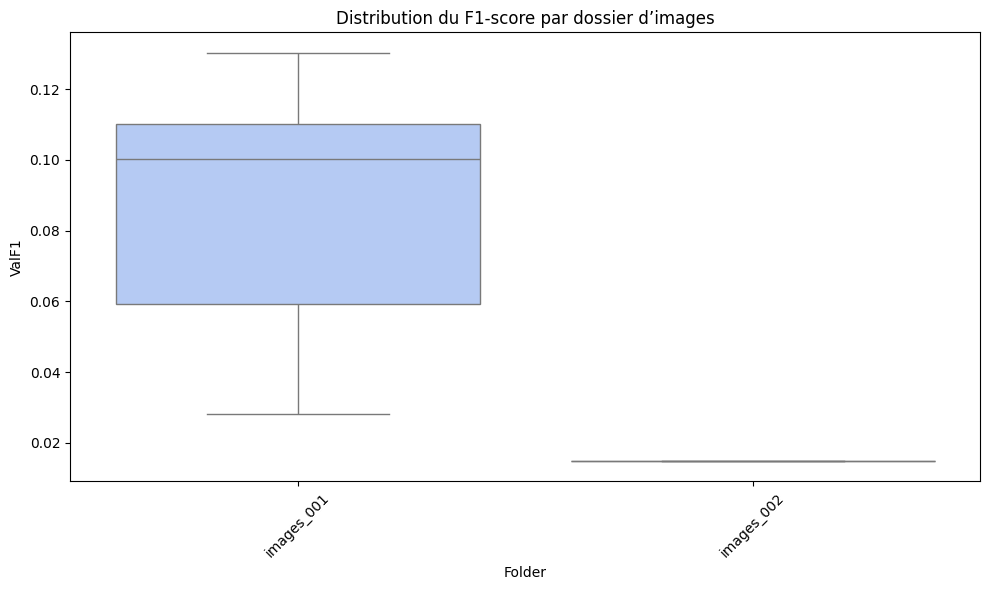

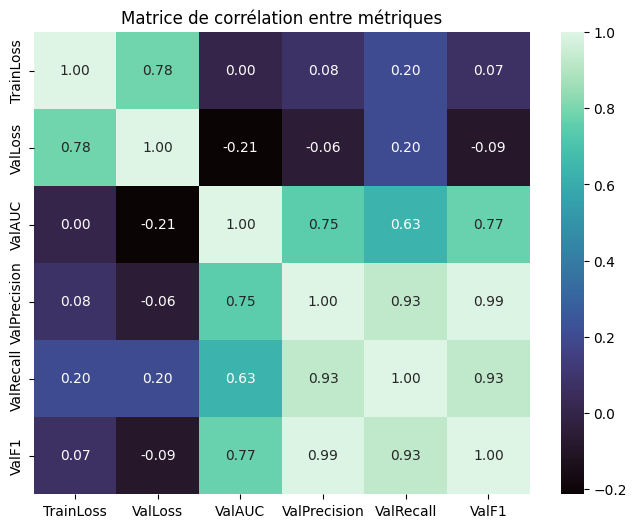

/tmp/ipython-input-575819632.py:95: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


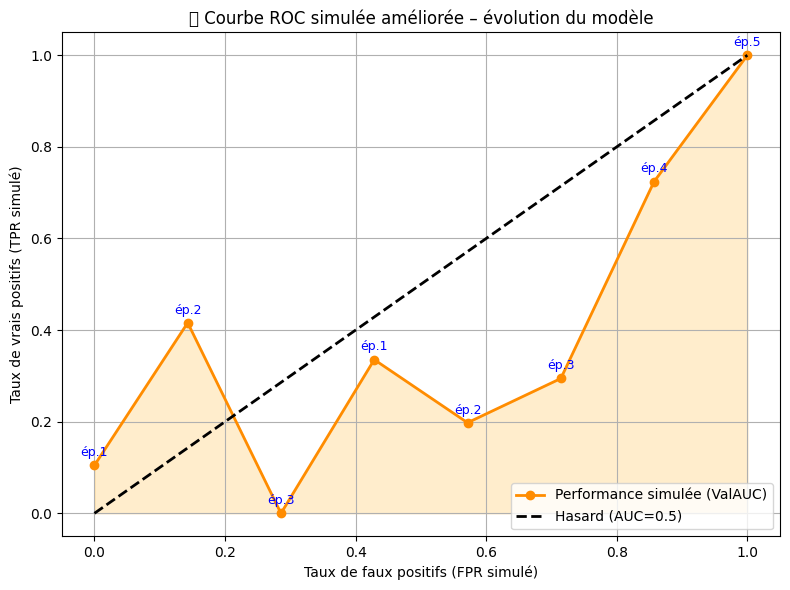

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

 #0) Mount Drive (force to avoid remount warning)
# -----------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# =====================================================
# 🔹 Lecture du CSV (déjà monté)
# =====================================================
csv_path = "/content/drive/MyDrive/NIH_ChestXray/training_results_swin.csv"
df = pd.read_csv(csv_path)

print("Dossiers présents :", df['Folder'].unique())
print("Colonnes disponibles :", df.columns.tolist())

# =====================================================
# 🎨 Courbes principales par époque (toutes métriques)
# =====================================================
plt.figure(figsize=(10,6))
plt.plot(df['Epoch'], df['ValAUC'], marker='o', label='AUC (validation)')
plt.plot(df['Epoch'], df['ValF1'], marker='s', label='F1-score (validation)')
plt.plot(df['Epoch'], df['ValPrecision'], marker='^', label='Précision (validation)')
plt.plot(df['Epoch'], df['ValRecall'], marker='d', label='Rappel (validation)')
plt.plot(df['Epoch'], df['TrainLoss'], '--', color='gray', label='Loss (train)')
plt.plot(df['Epoch'], df['ValLoss'], '--', color='black', label='Loss (val)')
plt.xlabel('Époque')
plt.ylabel('Valeur métrique')
plt.title('📈 Évolution des performances – Swin Transformer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# 🔹 Visualisation par dossier ("Folder")
# =====================================================
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Folder', y='ValAUC', palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution de l'AUC par dossier d’images")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Folder', y='ValF1', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Distribution du F1-score par dossier d’images")
plt.tight_layout()
plt.show()

# =====================================================
# 🔹 Corrélation entre métriques
# =====================================================
corr = df[['TrainLoss','ValLoss','ValAUC','ValPrecision','ValRecall','ValF1']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='mako', fmt=".2f")
plt.title("Matrice de corrélation entre métriques")
plt.show()

# =====================================================
# 🔹 Courbe ROC simulée améliorée (à partir du ValAUC)
# =====================================================
import numpy as np

plt.figure(figsize=(8,6))

# Normalisation pour donner une forme plus dynamique
auc_values = df['ValAUC'].values
epochs = df['Epoch'].values

# Simulation : variation progressive du FPR simulé
fpr_sim = np.linspace(0, 1, len(auc_values))
# On rend le TPR simulé proportionnel à l’évolution du ValAUC
tpr_sim = (auc_values - np.min(auc_values)) / (np.max(auc_values) - np.min(auc_values))

# Tracé principal
plt.plot(fpr_sim, tpr_sim, color='darkorange', lw=2, marker='o', label='Performance simulée (ValAUC)')
plt.fill_between(fpr_sim, tpr_sim, alpha=0.2, color='orange')

# Diagonale de hasard
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Hasard (AUC=0.5)')

# Annotation des époques
for i, ep in enumerate(epochs):
    plt.text(fpr_sim[i], tpr_sim[i] + 0.02, f"ép.{ep}", fontsize=9, color='blue', ha='center')

plt.xlabel('Taux de faux positifs (FPR simulé)')
plt.ylabel('Taux de vrais positifs (TPR simulé)')
plt.title('📊 Courbe ROC simulée améliorée – évolution du modèle')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
